In [ ]:
import math as M # funcion raiz cuadrada sqrt()
import statistics as St # funcion media mean()
import pandas as pd # uso de datos en DataFrames
import numpy as NP # Operaciones vectoriales
import matplotlib.pyplot as plt # Gráficas
pd.set_option('max_rows', None) # Mostrar todas las filas
pd.set_option('precision', 10) # Mostrar máximo 10 decimales

In [ ]:
### Este programa tiene como proposito calcular las regresiones para aproximar las series de datos
### del NIST Filip y Wampler3 usando los métodos de mínimos cuadrados polinomiales, ecuaciones
### normales y factorizacion QR. El programa fue elaborado por Misael Alvárez y Patricio Jolly. :D



## i,m = renglones / ecuaciones / datos
## j,n = columnas / coeficientes / grado - 1
## primero renglones, luego columnas


#funcion signo modificada para que sign(0)=1
def sign(x):
  if x >= 0:
    return 1
  return -1

#intercambiar renglones por columnas
def transpose(A):
  m = len(A)
  n = len(A[0])
  AT = [[A[j][i] for j in range(m)] for i in range(n)]
  
  for j in range(m):
    for i in range(n):
      AT[i][j] = A[j][i]
      
  return AT

#producto interno euclidiano para vectores en Rn
def innerProduct(u,v):
  n = len(u)
  return sum(u[i]*v[i] for i in range(n))

#multiplicar matrices mxp y pxn
def matrixMultiplication(A,B):
  m = len(A)
  n = len(B[0])
  p = len(B)
  C = [[] for i in range(m)]

  for i in range(m):
    for j in range(n):
      C[i].append(sum(A[i][k]*B[k][j] for k in range(p)))

  return C

#norma euclidiana de un vector
def norm2(v):
  return M.sqrt(sum(vi**2 for vi in v))

#sustitucion hacia atras para sistemas triangulares superiores
def backwardSubstitution(U,b):
  n = len(U)
  x = [0 for i in range(n)]

  for i in range(n-1,-1,-1):
    S = sum(U[i][j]*x[j] for j in range(n-1,i,-1))
    x[i] = 1 / U[i][i] * (b[i] - S)
  
  return x

#factorizacion LU con pivoteo parcial
def LUPartialPivoting(A,b):
  n = len(A)
  U = A
  y = b

  for k in range(n-1):
    p = k
    for i in range(k,n):
      if abs(U[i][k]) >= abs(U[p][k]):
        p = i
    if p != k: 
      U[p], U[k] = U[k], U[p]
      y[p], y[k] = y[k], y[p]
    for i in range(k+1,n):
      w = U[i][k] / U[k][k]
      for j in range(k+1,n):
        U[i][j] -= w*U[k][j]
      y[i] -= w*y[k]

  return [U,y]

#resolucion de un sistema por factorizacion LU
def LUSolve(A,b):
  [U,y] = LUPartialPivoting(A,b)
  return backwardSubstitution(U,y)
  
#calcula las entradas de Q en cada iteracion de Householder y coloca entradas de 
#la identidad en los renglones que no se han visitado
def entradasQ(Qmenor, i, j, k):
  if i<k or j<k:
    return float(i == j)
  return Qmenor[i-k][j-k]

#factorizacion QR mediante reflexiones de Householder
def householderQR(A):
  n = len(A)
  R = A
  QT = [[0 for i in range(n)] for j in range(n)]

  for k in range(n-1):
    u = [r[k] for r in R[k:]]
    a1 = -sign(u[0])*norm2(u)
    u[0] += a1
    Nu = norm2(u)
    u = [ui/Nu for ui in u]

    Qmenor = [[float(i==j) - 2*u[i]*u[j] for i in range(n-k)] for j in range(n-k)]
    Qi = [[entradasQ(Qmenor,i,j,k) for i in range(n)] for j in range(n)]

    if k == 0:
      QT = Qi
      R = matrixMultiplication(Qi,A)
    else:
      QT = matrixMultiplication(Qi,QT)
      R = matrixMultiplication(Qi,R)
      
  return [QT, R]
  
#Resolver sistema nxn por factorizacion QR
def QRSolve(A,b):
  [QT,R] = householderQR(A)
  y = transpose(matrixMultiplication(QT,transpose([b])))[0]
  return backwardSubstitution(R,y)

#matriz de diseño para ecuaciones normales
def designMatrix(n, datos):
  m = len(datos)
  A = [[datos[i][0]**j for j in range(n)] for i in range(m)]
  return A

#Prepara para ejecutar regresion por ecuaciones normales y QR
def normalEquationsSetup(n, datos):
  m = len(datos)
  b = transpose([[datos[i][1] for i in range(m)]])
  A = designMatrix(n, datos)    
  AT = transpose(A)
  ATA = matrixMultiplication(AT,A)
  ATb = transpose(matrixMultiplication(AT,b))[0]
  
  return [ATA, ATb]

#regresion por minimos cuadrados polinomiales
def polynomialRegression(n, datos):
  m = len(datos)
  S = [sum(datos[i][0]**j for i in range(m)) for j in range(2*n-1)]
  A = [[S[i+j] for j in range(n)] for i in range(n)]
  b = [sum(datos[i][1]*datos[i][0]**j for i in range(m)) for j in range(n)]
  return LUSolve(A,b)

#regresion por metodo de ecuaciones normales
def normalEquationsRegression(n, datos): 
  [ATA,ATb] = normalEquationsSetup(n, datos)
  return LUSolve(ATA,ATb)
  
#regresion por metodo de ecuaciones normales con factorizacion QR
def QRRegression(n, datos):
  [ATA, ATb] = normalEquationsSetup(n, datos)
  return QRSolve(ATA,ATb)

#calcula estadisticos para validar los resultados obtenidos
def estadisticos(reg, n, datos):
  m = len(datos)
  A = designMatrix(n, datos)
  y = [datos[i][1] for i in range(m)]
  Areg = transpose(matrixMultiplication(A,transpose([reg])))[0]
  ymean = St.mean(reg)

  #Norma Residual
  err = [y[i]-Areg[i] for i in range(m)]
  NR = norm2(err)
  
  #Suma Residual de Cuadrados
  RSS = innerProduct(err,err)
  
  #Media Residual Cuadrada
  RMS = RSS/(m-n)

  #Desviacion Estandar Residual
  RSD = M.sqrt(RMS)
  
  #R cuadrada
  RS = 1 - RSS/(abs(innerProduct(y,y)-ymean**2))

  #Suma de Cuadrados de Regresion
  v = [Areg[i]-ymean for i in range(m)]
  SSR = innerProduct(v,v)

  #Media de Cuadrados de Regresion
  MSR = SSR / (n-1)

  #Estadistico F
  Fstat = MSR / RMS
  
  return [NR, RSS,RMS,RSD,RS,SSR,MSR,Fstat]

In [ ]:
from numpy.ma.core import array
df = pd.read_csv("https://raw.githubusercontent.com/Misael-Alvarez/DataITL/main/Data.csv")
df = df.reindex(columns=['x','y'])
x = df['x'].tolist()
y = df['y'].tolist()
data = list(zip(x,y))
m1 = 11

# NIST Filip
RSS = [0.795851382172941e-03] # Residual sum of squares
RMS = [0.112091743968020e-04] # Residual mean square
RSD = [0.334801051324544e-02] # Residual standard deviation
RS = [0.996727416185620] # R–squared
SSR = [0.242391619837339] # regression sum of squares
MSR = [0.242391619837339e-01] # Regression mean square
Fstat = [2162.43954511489] # F_Statistic

In [ ]:
print("FILIP - MINIMOS CUADRADOS POLINOMIALES")
B1 = polynomialRegression(m1, data)
print("Coeficientes: ")
for i in range(m1):
  print(B1[i])
print()
[NR1,RSS1,RMS1,RSD1,RS1,SSR1,MSR1,Fstat1] = estadisticos(B1, m1, data)
print("Norma Residual = ", NR1)
print("Suma Residual de Cuadrados = ", RSS1)
print("Media Residual Cuadrada = ", RMS1)
print("Desviacion Estandar Residual = ", RSD1)
print("R Cuadrada = ", RS1)
print("Suma de Cuadrados de Regresion = ", SSR1)
print("Media de Cuadrados de Regresion = ", MSR1)
print("Estadistico F = ", Fstat1)
print("\n\n")


print("FILIP - ECUACIONES NORMALES")
B2 = normalEquationsRegression(m1, data)
print("Coeficientes: ")
for i in range(m1):
  print(B2[i])
print()
[NR2,RSS2,RMS2,RSD2,RS2,SSR2,MSR2,Fstat2] = estadisticos(B2, m1, data)
print("Norma Residual = ", NR2)
print("Suma Residual de Cuadrados = ", RSS2)
print("Media Residual Cuadrada = ", RMS2)
print("Desviacion Estandar Residual = ", RSD2)
print("R Cuadrada = ", RS2)
print("Suma de Cuadrados de Regresion = ", SSR2)
print("Media de Cuadrados de Regresion = ", MSR2)
print("Estadistico F = ", Fstat2)
print("\n\n")


print("FILIP - QR HOUSEHOLDER")
B3 = QRRegression(m1, data)
print("Coeficientes: ")
for i in range(m1):
  print(B3[i])
print()
[NR3,RSS3,RMS3,RSD3,RS3,SSR3,MSR3,Fstat3] = estadisticos(B3, m1, data)
print("Norma Residual = ", NR3)
print("Suma Residual de Cuadrados = ", RSS3)
print("Media Residual Cuadrada = ", RMS3)
print("Desviacion Estandar Residual = ", RSD3)
print("R Cuadrada = ", RS3)
print("Suma de Cuadrados de Regresion = ", SSR3)
print("Media de Cuadrados de Regresion = ", MSR3)
print("Estadistico F = ", Fstat3)
print("\n\n")

FILIP - MINIMOS CUADRADOS POLINOMIALES
Coeficientes: 
-473.4847574042437
-771.4518547070297
-537.2965537718707
-207.40070568946055
-47.40431404567705
-6.098921490473254
-0.2811747814771198
0.03467527243604792
0.006345231720457865
0.00039628755411088765
9.294754724582939e-06

Norma Residual =  0.042447487454753435
Suma Residual de Cuadrados =  0.0018017891912214502
Media Residual Cuadrada =  2.537731255241479e-05
Desviacion Estandar Residual =  0.005037589954771507
R Cuadrada =  0.9999999476952657
Suma de Cuadrados de Regresion =  2855544.1033278145
Media de Cuadrados de Regresion =  285554.41033278144
Estadistico F =  11252350292.923723



FILIP - ECUACIONES NORMALES
Coeficientes: 
-89.65346695047836
-161.10642713830194
-122.4354908919792
-51.44125457553324
-12.778712393854496
-1.7947936785623355
-0.09642360575392481
0.009815205048332255
0.002050108090998417
0.00013645082336586275
3.3613215586465152e-06

Norma Residual =  0.03261236637320921
Suma Residual de Cuadrados =  0.001063566440

In [ ]:
B = []

# Original
B.append([ -1467.48961422980, 
           -2772.17959193342, 
           -2316.37108160893, 
           -1127.97394098372,  
           -354.478233703349, 
            -75.1242017393757,
            -10.8753180355343, 
            -1.06221498588947, 
            -0.670191154593408E-01,
            -0.246781078275479E-02, 
            -0.402962525080404E-04  ])

# Polinomial
B.append(B1)
# Normal
B.append(B2)
# QR
B.append(B3)

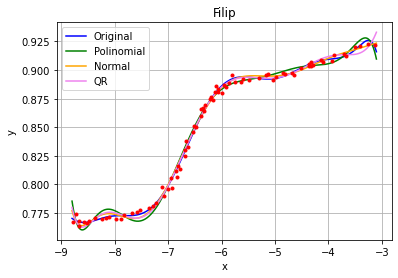

In [ ]:
def f(i,x):
  return sum(B[i][j]*x**j for j in range(m1))

colores = ["blue", "green", "orange", "violet"]
    
xx = NP.arange(-8.8,-3.1,0.001)

for i in range(4):
  plt.plot(xx,[f(i,k) for k in xx ], c = colores[i])

#Grafica
plt.legend(('Original', 'Polinomial','Normal' ,'QR'),
  prop = {'size':10}, loc = 'upper left')
plt.plot(x,y,'or',markersize=3)
plt.title("Filip")
plt.xlabel("x")
plt.grid()
plt.ylabel("y")
plt.show()

In [ ]:
df2 = pd.read_csv("https://raw.githubusercontent.com/Misael-Alvarez/DataITL/main/data2.csv")
df2 = df2.reindex(columns=['x','y'])
x2 = df2['x'].tolist()
y2 = df2['y'].tolist()
data2 = list(zip(x2,y2))
m2 = 6

#NIST Wampler3
RSS = [83554268.0000000]  # Residual sum os squares
RMS = [5570284.53333333]  # Residual mean square
RSD = [2360.14502379268]  # Residual standard deviation
RS = [0.999995559025820]  # R–squared
SSReg = [18814317208116.7]   # regression sum of squares
MSReg = [3762863441623.33]  # Regression mean square
MSReg_RMS = [675524.458240122] # F_Statistic

In [ ]:
print("WAMPLER3 - MINIMOS CUADRADOS POLINOMIALES")
A4 = polynomialRegression(m2, data2)
print("Coeficientes: ")
for i in range(m2):
  print(A4[i])
print()
[NR4,RSS4,RMS4,RSD4,RS4,SSR4,MSR4,Fstat4] = estadisticos(A4, m2, data2)
print("Norma Residual = ", NR4)
print("Suma Residual de Cuadrados = ", RSS4)
print("Media Residual Cuadrada = ", RMS4)
print("Desviacion Estandar Residual = ", RSD4)
print("R Cuadrada = ", RS4)
print("Suma de Cuadrados de Regresion = ", SSR4)
print("Media de Cuadrados de Regresion = ", MSR4)
print("Estadistico F = ", Fstat4)
print("\n\n")



print("WAMPLER3 - ECUACIONES NORMALES")
A5 = normalEquationsRegression(m2, data2)
print("Coeficientes: ")
for i in range(m2):
  print(A5[i])
print()
[NR5,RSS5,RMS5,RSD5,RS5,SSR5,MSR5,Fstat5] = estadisticos(A5, m2, data2)
print("Norma Residual = ", NR5)
print("Suma Residual de Cuadrados = ", RSS5)
print("Media Residual Cuadrada = ", RMS5)
print("Desviacion Estandar Residual = ", RSD5)
print("R Cuadrada = ", RS5)
print("Suma de Cuadrados de Regresion = ", SSR5)
print("Media de Cuadrados de Regresion = ", MSR5)
print("Estadistico F = ", Fstat5)
print("\n\n")


print("WAMPLER3 - QR HOUSEHOLDER")
A6 = QRRegression(m2, data2)
print("Coeficientes: ")
for i in range(m2):
  print(A6[i])
print()
[NR6,RSS6,RMS6,RSD6,RS6,SSR6,MSR6,Fstat6] = estadisticos(A6, m2, data2)
print("Norma Residual = ", NR6)
print("Suma Residual de Cuadrados = ", RSS6)
print("Media Residual Cuadrada = ", RMS6)
print("Desviacion Estandar Residual = ", RSD6)
print("R Cuadrada = ", RS6)
print("Suma de Cuadrados de Regresion = ", SSR6)
print("Media de Cuadrados de Regresion = ", MSR6)
print("Estadistico F = ", Fstat6)

WAMPLER3 - MINIMOS CUADRADOS POLINOMIALES
Coeficientes: 
0.9999999046661275
1.0000002261152676
0.9999999119573761
1.0000000121833077
0.9999999993067861
1.0000000000138545

Norma Residual =  9140.80237178342
Suma Residual de Cuadrados =  83554268.0000014
Media Residual Cuadrada =  5570284.533333426
Desviacion Estandar Residual =  2360.145023792696
R Cuadrada =  0.9999969042804095
Suma de Cuadrados de Regresion =  26990147450845.77
Media de Cuadrados de Regresion =  5398029490169.154
Estadistico F =  969076.0782266199



WAMPLER3 - ECUACIONES NORMALES
Coeficientes: 
0.9999999046661275
1.0000002261152676
0.9999999119573761
1.0000000121833077
0.9999999993067861
1.0000000000138545

Norma Residual =  9140.80237178342
Suma Residual de Cuadrados =  83554268.0000014
Media Residual Cuadrada =  5570284.533333426
Desviacion Estandar Residual =  2360.145023792696
R Cuadrada =  0.9999969042804095
Suma de Cuadrados de Regresion =  26990147450845.77
Media de Cuadrados de Regresion =  5398029490169.154

In [ ]:
A = []
# Original
A.append([ 1.00000000000000,    
           1.00000000000000, 
           1.00000000000000, 
           1.00000000000000,  
           1.00000000000000,     
           1.00000000000000   ])

# Regresión
A.append(A4)
# Normal
A.append(A5)
# QR
A.append(A6)

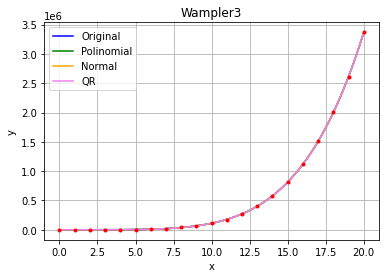

In [ ]:
def g(i,x):
  return sum(A[i][j]*x**j for j in range(m2))
    
xx2 = NP.arange(0,20,0.001)
    
for i in range(4):
  plt.plot(xx2,[g(i,k) for k in xx2], c = colores[i])

#Grafica
plt.legend(('Original', 'Polinomial','Normal' ,'QR'),
  prop = {'size':10}, loc = 'upper left')
plt.plot(x2,y2,'or',markersize=3)
plt.title("Wampler3")
plt.xlabel("x")
plt.grid()
plt.ylabel("y")
plt.show()